<a href="https://colab.research.google.com/github/enVives/TFG/blob/main/EvaluacioArquitectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import torch
import cv2
import random
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import wandb
import pylab as pl


from glob import glob
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch import nn
from torch.utils.data import Dataset
from google.colab import files
from IPython.display import clear_output,display
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage import io

WEIGHTSANDBIASES = True
DOWNLOAD = False
# ORIGEN = '/content/drive/MyDrive/HAM10000/skin-cancer-mnist-ham10000/'

# from google.colab import drive
# drive.mount('/content/drive')

if DOWNLOAD:
  !rm -rf /content/sample_data/*

  !kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

  !unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

#471be466c8949671a46c67e7aad0d5a0ac8c9dad

if WEIGHTSANDBIASES:
  wandb.login()

#torch.cuda.default_stream(torch.device('cuda'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

!rm -rf /content/sample_data/*

!kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

!unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

In [30]:

metadates = pd.read_csv('/content/sample_data/HAM10000_metadata.csv')
metadates = metadates.sort_values(by='image_id')
metadates.head()
print(metadates['dx'].value_counts())
print()
print(metadates['dx'].value_counts() / sum(metadates['dx'].value_counts()))

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: count, dtype: float64


nv: melanocytic nevi

vasc: vascular lesions

mel:melanoma

df: dermatofibroma

bkl: benign keratosis-like lesions

bcc: basal cell carcinoma

akiec: Actinic keratoses and intraepithelial carcinoma / Bowen's disease

In [31]:
class Formes(Dataset):
  #Classe on gestionarem les imatges dels fitxers
  dict_illnesses = {0 : 'nv', 1 : 'mel', 2 : 'bkl', 3 : 'bcc', 4 : 'akiec', 5 : 'vasc', 6 : 'df'}

  def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform
        #Per defecte pens que el color pot extreure característiques importants, per tant en primer lloc
        #entrenarem les imatges de color
        self.greyscale = False

  def __len__(self):
        return self.len

  def __addlabel__(self,label):
    self.labels = np.append(self.labels,label)

  def __addPath__(self,path):
    self.paths = np.append(self.paths,path)

  def __getdist__(self):
    return pd.Series(self.labels).value_counts()

  def __getlabels__(self):
    classes = [[],[],[],[],[],[],[]]
    for i in range(len(self.labels)):
      classes[self.labels[i]].append(i) #afegim l'index
    return classes

  def __redistribute__(self,percentages):
    #percentages: [15,15,10,10,5,5] percentatges que volem pujar de la resta de classes llevat de nv
    threshold = 0.005  #percentatge de marge que deixam a la redistribució
    Ntarget = self.len
    classes = self.__getlabels__() #indexos de cada clase
    afegir = np.array([0,0,0,0,0,0],dtype=np.int64) # de nv mai haurem d'afegir

    nmel = len(classes[1]) #nombre inicial de cada clase
    nbkl = len(classes[2])
    nbcc = len(classes[3])
    nakiec = len(classes[4])
    nvasc = len(classes[5])
    ndf = len(classes[6])

    while True:

      suma_actual = afegir.sum()

      operacio = percentages[0]*Ntarget - nmel
      afegir[0] +=  operacio if operacio > 0 else 0
      nmel += operacio if operacio > 0 else 0

      operacio = percentages[1]*Ntarget - nbkl
      afegir[1] += operacio if operacio > 0 else 0
      nbkl += operacio if operacio > 0 else 0

      operacio = percentages[2]*Ntarget - nbcc
      afegir[2] += operacio if operacio > 0 else 0
      nbcc += operacio if operacio > 0 else 0

      operacio = percentages[3]*Ntarget - nakiec
      afegir[3] += operacio if operacio > 0 else 0
      nakiec += operacio if operacio > 0 else 0

      operacio = percentages[4]*Ntarget - nvasc
      afegir[4] += operacio if operacio > 0 else 0
      nvasc += operacio if operacio > 0 else 0

      operacio = percentages[5]*Ntarget - ndf
      afegir[5] += operacio if operacio > 0 else 0
      ndf += operacio if operacio > 0 else 0

      if (afegir.sum()-suma_actual) < Ntarget*threshold:
        break

      Ntarget += (afegir.sum()-suma_actual)

    #Quedaria afegir a les imatges les còpies
    for i in range(len(afegir)):
      for j in range(afegir[i]):

          self.__addPath__(self.paths[classes[i+1][random.randint(0, len(classes[i+1]) - 1)]])
          self.__addlabel__(i+1)

    self.len = len(self.labels)

  def __setgreyscale__(self,mode):
    self.greyscale = mode

  def __getitem__(self, index):
      path = self.paths[index]
      label = self.labels[index]

      image = cv2.imread(path, cv2.IMREAD_GRAYSCALE if self.greyscale else cv2.IMREAD_COLOR)

      if self.greyscale:
        image = Image.fromarray(image, mode="L")
      else:
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      image = self.transform(image)

      return image, label

In [32]:
def calcula_mitjana_desviacio(img_files_path):
  mitjana = np.array([0.0, 0.0, 0.0], dtype=np.float64)
  desviacio = np.array([0.0, 0.0, 0.0], dtype=np.float64)

  x,y = 256,256
  pixels_totals_canal = len(img_files_path) * x * y

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)

    mitjana += np.array([canal_r.sum(), canal_g.sum(), canal_b.sum()])
    #desviacio += np.array([(canal_r**2).sum(), (canal_g**2).sum(), (canal_b**2).sum()])

  mitjana = mitjana / pixels_totals_canal

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)
    desviacio += np.array([((canal_r-mitjana[0])**2).sum(), ((canal_g-mitjana[1])**2).sum(), ((canal_b-mitjana[2])**2).sum()])


  desviacio = np.sqrt(desviacio / pixels_totals_canal)

  return mitjana,desviacio

In [33]:
def load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

  illnes_dictionary = {
      'nv': 'Melanocytic nevi',
      'mel': 'Melanoma',
      'bkl': 'Benign keratosis-like lesions ',
      'bcc': 'Basal cell carcinoma',
      'akiec': 'Actinic keratoses and intraepithelial carcinoma / Bowens disease',
      'vasc': 'Vascular lesions',
      'df': 'Dermatofibroma'
  }

  img_files_1 = sorted(glob('/content/sample_data/HAM10000_images_part_1/*'))
  img_files_2 = sorted(glob('/content/sample_data/HAM10000_images_part_2/*'))
  img_files = img_files_1 + img_files_2

  img_files = np.array(img_files)


  imgid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in img_files}

  metadates['path'] = metadates['image_id'].map(imgid_path_dict.get)
  metadates['illness'] = metadates['dx'].map(illnes_dictionary.get)
  metadates['illness_code'] = metadates['dx'].map({'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6})

  #Aquest illness_code s'utilitzarà com a label de la enfermetat

  img_number = len(img_files)

  X = metadates.drop('illness_code',axis= 1)
  y = metadates['illness_code']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testing_dist, random_state=42, stratify=y)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valitation_dist/(training_dist+valitation_dist), random_state=42, stratify=y_train)

  #Una bona idea seria aplicar data augmentation al conjunt d'entrenament ja que les classes estan molt desbalancejades
  #Una altra bona idea seria emplear una funció de pèrdua que tengui en compte les classes desbalancejades.

  #Antes de guardar els datasets en classes Formes, hauriem de caluclar la mitjana i desviació típica de les imatges
  train_data = Formes(X_train['path'].to_numpy(),y_train.to_numpy(),transformation_training)
  test_data = Formes(X_test['path'].to_numpy(),y_test.to_numpy(),transformation_default)
  validation_data = Formes(X_val['path'].to_numpy(),y_val.to_numpy(),transformation_default)


  #prova1: [0.12,0.12,0.06,0.04,0.02,0.02]
  #prova2: [0.12,0.12,0.06,0.04,0.02,0.015]
  #prova3: [0.13,0.13,0.07,0.05,0.02,0.015]

  if distribution != None:
    train_data.__redistribute__(distribution)

  print(train_data.__getdist__())
  print(train_data.len)

  return train_data, test_data,validation_data


In [34]:
def veure_imatges(train_data,std,mean):
  for i in range(len(train_data)):
    imatge,label = train_data.__getitem__(i)

    imatge = imatge * (std[:, None, None]*255) + (mean[:, None, None]*255)

    # Convert the tensor back to a NumPy array
    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    cv2_imshow(img_numpy)
    time.sleep(5)
    clear_output(wait=True)

In [35]:
def get_weights():
  #diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  valors = metadates['dx'].value_counts()
  print(valors)
  illnesses = valors.keys()
  weights = np.zeros(len(illnesses))

  i = 0
  for x in illnesses:
    y = valors[x]
    weights[i] = valors.sum() / y
    i+= 1



  weights[1] *= 2.0
  weights[3] *= 2.0
  weights[4] *= 2.0


  weights = weights / weights.sum()


  return (1 - (weights[1]+weights[3]+weights[4])) / (weights[1]+weights[3]+weights[4])

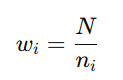

[0.00657042, **0.03958192**, 0.04008614, **0.08570948**, **0.13472377**, 0.31024417,
 0.3830841 ]

 provarem a augmentar en 1.5 els pesos de les enfermetats perilloses:

[0.00581449, 0.05254201, 0.03547423, 0.11377288, 0.17883566, 0.27455052,
 0.33901021]

 i en 2.0:

 [0.00521456, 0.06282768, 0.03181402, 0.13604515, 0.21384468, 0.24622257,
 0.30403135]

 Això pujarà el pes conjunt de les classes perilloses fins a 41%

In [36]:
#veure_imatges(train_data,std,mean)

Ara ja tenim el training preparat. El provarem amb el validation a continuació

##ENTRENAMENT

In [37]:
def tria_model(numero_model,weights):
  if numero_model == 0:
    alexnetbinary = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

    alexnetbinary.classifier = nn.Sequential(
    torch.nn.Linear(9216, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 512),
    nn.ReLU(),
    torch.nn.Linear(512, 1)
    )
    pos_weight = torch.tensor(weights,device = device)
    # print(pos_weight.shape)
    # print(pos_weight)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return alexnetbinary,loss_fn

  elif numero_model == 1:
    resnetbinary = models.resnet50(weights="IMAGENET1K_V1")
    resnetbinary.fc = nn.Linear(in_features=2048, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 2:
    resnetbinary = models.resnet152(weights="IMAGENET1K_V1")
    resnetbinary.fc = nn.Linear(in_features=2048, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 6:
    # alexnetmulticlass = models.alexnet(weights=None)

    # alexnetmulticlass.classifier = nn.Sequential(
    # torch.nn.Linear(9216, 1024),
    # nn.ReLU(),
    # torch.nn.Linear(1024, 1024),
    # nn.ReLU(),
    # torch.nn.Linear(1024, 512),
    # nn.ReLU(),
    # torch.nn.Linear(512, 7),  # Ja que tenim 7 classes.
    # nn.Softmax(dim=1)
    # )
    # loss_fn = nn.CrossEntropyLoss()

    # return alexnetmulticlass,loss_fn
    return




In [38]:
def converteix_a_binari(target):
  #{'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}
  diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  target = ([[str(num.item())] for num in target])

  mapped_tensor = torch.tensor([[diseases[num[0]]] for num in target])
  return mapped_tensor

In [39]:
def train(model,loss_fn,dataloader,optimizer,epoch,device):

  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0
  train_loss = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):
        model.train()
        optimizer.zero_grad()

        target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
        target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no
        target = target.to(device)


        input_img = input_img.to(device)
        output = model(input_img.to(device))

        loss = loss_fn(output, target.float())

        output = torch.sigmoid(output)

        output = (output.cpu().detach().numpy() > 0.5).astype(int)

        target = target.cpu().detach().numpy()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            optimizer.step()

        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        train_acc += accuracy_score(target,output)
        train_f1 += f1_score(target,output,zero_division=1)
        train_recall += recall_score(target,output,zero_division=1)
        train_precision += precision_score(target,output,zero_division=1)
        train_loss += loss.item()

  return train_acc,train_f1,train_recall,train_precision,train_loss


In [40]:
def validate(model,loss_fn,data_loader,device):
  val_acc = 0
  val_f1 = 0
  val_recall = 0
  val_precision = 0
  val_loss = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):
            input_img = input_img.to(device)


            target = torch.unsqueeze(target, 1)
            target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no
            target = target.to(device)

            output = model(input_img)
            loss = loss_fn(output, target.float())

            output = torch.sigmoid(output)
            output = (output.cpu().detach().numpy() > 0.5).astype(int)
            target = target.cpu().detach().numpy()

            val_acc  += accuracy_score(target,output)
            val_f1 += f1_score(target,output,zero_division=1)
            val_recall += recall_score(target,output,zero_division=1)
            val_precision += precision_score(target,output,zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [41]:
def execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,epochs,device):

  t_loss = np.zeros(epochs)
  v_loss = np.zeros(epochs)
  acc_t = np.zeros(epochs)
  acc_v = np.zeros(epochs)
  f1_t = np.zeros(epochs)
  f1_v = np.zeros(epochs)
  recall_t = np.zeros(epochs)
  recall_v = np.zeros(epochs)
  architecrures_inv = {0: 'alexnet',1:'vgg',2:'resnet'}

  patiente = 100
  best_recall = 0

  pbar = tqdm(range(1, epochs + 1))  # tdqm permet tenir text dinàmic

  for epoch in pbar:

      train_loss = 0
      train_acc = 0
      train_precision = 0
      train_f1 = 0
      train_recall = 0
      val_acc = 0
      val_recall = 0
      val_f1 = 0
      val_loss = 0
      val_precision = 0

      batch_num = 1

      train_acc,train_f1,train_recall,train_precision,train_loss = train(model,loss_fn,train_loader,optimizer,epoch,device)

      val_acc,val_f1,val_recall,val_precision,val_loss  = validate(model,loss_fn,val_loader,device)

      if WEIGHTSANDBIASES:

        training_metrics = {"train/train_loss": train_loss/len(train_loader),
                        "train/train_acc":train_acc/len(train_loader),
                        "train/train_f1":train_f1/len(train_loader),
                        "train/train_recall":train_recall/len(train_loader),
                        "train/train_precision":train_precision/len(train_loader)}

        val_metrics = {"val/val_loss": val_loss/len(val_loader),
                      "val/val_acc":val_acc/len(val_loader),
                      "val/val_f1":val_f1/len(val_loader),
                      "val/val_recall": val_recall/len(val_loader),
                      "val/val_precision": val_precision/len(val_loader)}

        wandb.log({**training_metrics, **val_metrics})

        # torch.save(model, "my_model.pt")
        # wandb.log_model("./my_model.pt", architecrures_inv[MODEL], aliases=[f"epoch-{epoch+1}"])

      # RESULTATS
      train_loss /= len(train_loader)
      train_acc /= len(train_loader)
      train_f1 /= len(train_loader)
      train_recall /= len(train_loader)
      train_precision /= len(train_loader)

      print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
      print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
      print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
      print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")

      val_loss /= len(val_loader)
      val_acc /= len(val_loader)
      val_f1 /= len(val_loader)
      val_recall /= len(val_loader)

      print()
      print()
      print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
      print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
      print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
      print(f"Recall val epoch: {epoch}  val_reall: {val_recall}")

      if val_recall > best_recall:
        best_recall = val_recall
        patiente = 100
      else:
        patiente -= 1

      if patiente == 0:
        print("Early Sopping")
        break

  wandb.finish()

In [42]:
from itertools import product
BINARY = True #Si volem que el resultat de la classificació sigui 0 i 1

architectures = {'alexnet': 0,'resnet': 1,'resnet152':2}
MODEL = architectures['resnet152']

TRAINING = 0.75
VALIDATION = 0.15
TESTING = 0.10
SIZE = 224


mean = torch.tensor([194.57463374, 139.13953272, 145.36132088]) /255 #rgb
std = torch.tensor([35.92275236, 38.90347617, 43.33101831]) / 255

TRANSFORMATIONS = []
#FINE_TUNING = [None,models.AlexNet_Weights.IMAGENET1K_V1]
DISTRIBUTIONS = None


transform = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std)
])

transform_training = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    #transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    #transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std),
])

#load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

train_data,validation_data,test_data = load_sets(transform_training,transform,TRAINING,VALIDATION,TESTING,DISTRIBUTIONS)

#Realitzar el tuning de hiperparàmetres aquí


EPOCHS = 50
batch_size = 32

#[0.00657042, 0.03958192, 0.04008614, 0.08570948, 0.13472377, 0.31024417, 0.3830841 ]
# WEIGHTS = [[0.00581449, 0.05254201, 0.03547423, 0.11377288, 0.17883566, 0.27455052, 0.33901021],
#  [0.00521456, 0.06282768, 0.03181402, 0.13604515, 0.21384468, 0.24622257, 0.30403135]]

#WEIGHTS = [2.33,1.5]

#get_weights()
WEIGHTS = [get_weights()]

learning_rate  = 1e-3

for weights in product(WEIGHTS):

  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

  model,loss_fn = tria_model(MODEL,weights)


  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  model.to(device)

  projectes = ['Ham10000-AlexnetBinary','Ham1000-ResnetBinary','Ham1000-Resnet152Binary']

  #print(f"{batch_size} , {weights} , {learning_rate}")
  if WEIGHTSANDBIASES:
      wandb.init(
              project=projectes[MODEL],
              config={
                  "epochs": EPOCHS,
                  "batch_size": batch_size,
                  "lr": learning_rate,
                  "trsize":len(train_loader),
                  "trdist":TRAINING,
                  "vsize":len(val_loader),
                  "vdist":VALIDATION,
                  "weights":weights,
                  })
      config = wandb.config
      print(config)

  execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,EPOCHS,device)

0    5028
1     835
2     824
3     386
4     245
5     106
6      86
Name: count, dtype: int64
7510
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 137MB/s]
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


{'epochs': 50, 'batch_size': 32, 'lr': 0.0001, 'trsize': 235, 'trdist': 0.75, 'vsize': 32, 'vdist': 0.15, 'weights': [1.4229647861576398]}


  0%|          | 0/50 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 0.45387538272015593
Accuracy train epoch: 1  train_acc: 0.8091392649903288
F1 train epoch: 1  train_f1: 0.4832799932455826
Recall train epoch: 1  train_recall: 0.511638845787782


Pèrdua validació epoch: 1  val_loss: 0.3890806334093213
Accuracy val epoch: 1  val_acc: 0.8416015625
F1 val epoch: 1  val_f1: 0.6451037088346324
Recall val epoch: 1  val_reall: 0.7739324044011544


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.4147023551007535
Accuracy train epoch: 2  train_acc: 0.838394584139265
F1 train epoch: 2  train_f1: 0.5527504430224937
Recall train epoch: 2  train_recall: 0.5554243274456039


Pèrdua validació epoch: 2  val_loss: 0.36669652070850134
Accuracy val epoch: 2  val_acc: 0.8630859375
F1 val epoch: 2  val_f1: 0.4972413003663002
Recall val epoch: 2  val_reall: 0.4108630952380953


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.3880416636771344
Accuracy train epoch: 3  train_acc: 0.855536750483559
F1 train epoch: 3  train_f1: 0.6106058604461214
Recall train epoch: 3  train_recall: 0.6270366512919705


Pèrdua validació epoch: 3  val_loss: 0.36164947552606463
Accuracy val epoch: 3  val_acc: 0.8689453125
F1 val epoch: 3  val_f1: 0.634130713036963
Recall val epoch: 3  val_reall: 0.6370840097402595


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.36930923189254516
Accuracy train epoch: 4  train_acc: 0.8624637330754352
F1 train epoch: 4  train_f1: 0.627578726596578
Recall train epoch: 4  train_recall: 0.6399267517352623


Pèrdua validació epoch: 4  val_loss: 0.365459640044719
Accuracy val epoch: 4  val_acc: 0.8294921875
F1 val epoch: 4  val_f1: 0.6452809097016974
Recall val epoch: 4  val_reall: 0.8284598214285716


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.3544266054604916
Accuracy train epoch: 5  train_acc: 0.8696204061895552
F1 train epoch: 5  train_f1: 0.6475595436701429
Recall train epoch: 5  train_recall: 0.6673054250713825


Pèrdua validació epoch: 5  val_loss: 0.36720190243795514
Accuracy val epoch: 5  val_acc: 0.8865234375
F1 val epoch: 5  val_f1: 0.6150131164522611
Recall val epoch: 5  val_reall: 0.5374007936507937


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.3367753121447056
Accuracy train epoch: 6  train_acc: 0.8738878143133463
F1 train epoch: 6  train_f1: 0.6521779813918012
Recall train epoch: 6  train_recall: 0.6603930584781651


Pèrdua validació epoch: 6  val_loss: 0.3683175900951028
Accuracy val epoch: 6  val_acc: 0.88359375
F1 val epoch: 6  val_f1: 0.5930314477189477
Recall val epoch: 6  val_reall: 0.5114278950216449


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.3301445229890499
Accuracy train epoch: 7  train_acc: 0.8761484526112187
F1 train epoch: 7  train_f1: 0.6752395042734649
Recall train epoch: 7  train_recall: 0.7111218568665378


Pèrdua validació epoch: 7  val_loss: 0.31643183901906013
Accuracy val epoch: 7  val_acc: 0.89453125
F1 val epoch: 7  val_f1: 0.7226021425469956
Recall val epoch: 7  val_reall: 0.7434129238816739


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.32379507837777444
Accuracy train epoch: 8  train_acc: 0.8822050290135396
F1 train epoch: 8  train_f1: 0.6835262412026557
Recall train epoch: 8  train_recall: 0.7136972483780993


Pèrdua validació epoch: 8  val_loss: 0.4892203616909683
Accuracy val epoch: 8  val_acc: 0.8541015625
F1 val epoch: 8  val_f1: 0.42068731250474667
Recall val epoch: 8  val_reall: 0.3140004960317461


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.3169626260691501
Accuracy train epoch: 9  train_acc: 0.882144584139265
F1 train epoch: 9  train_f1: 0.6783946854805166
Recall train epoch: 9  train_recall: 0.7031128918362959


Pèrdua validació epoch: 9  val_loss: 0.3425674862228334
Accuracy val epoch: 9  val_acc: 0.8818359375
F1 val epoch: 9  val_f1: 0.6627924408859975
Recall val epoch: 9  val_reall: 0.6642857142857145


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.3077064001179756
Accuracy train epoch: 10  train_acc: 0.8867746615087041
F1 train epoch: 10  train_f1: 0.6970058332784766
Recall train epoch: 10  train_recall: 0.7241904077010461


Pèrdua validació epoch: 10  val_loss: 0.3482352043502033
Accuracy val epoch: 10  val_acc: 0.8818359375
F1 val epoch: 10  val_f1: 0.5615568276752487
Recall val epoch: 10  val_reall: 0.4469131562881563


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.2882907491732151
Accuracy train epoch: 11  train_acc: 0.8926257253384914
F1 train epoch: 11  train_f1: 0.7147650277401713
Recall train epoch: 11  train_recall: 0.7438546559823154


Pèrdua validació epoch: 11  val_loss: 0.3312570925336331
Accuracy val epoch: 11  val_acc: 0.8837890625
F1 val epoch: 11  val_f1: 0.6468413326869209
Recall val epoch: 11  val_reall: 0.5943080357142857


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.28262429322968136
Accuracy train epoch: 12  train_acc: 0.8962161508704063
F1 train epoch: 12  train_f1: 0.7263426316710029
Recall train epoch: 12  train_recall: 0.7812717306334327


Pèrdua validació epoch: 12  val_loss: 0.30341821745969355
Accuracy val epoch: 12  val_acc: 0.8884765625
F1 val epoch: 12  val_f1: 0.6588889201188765
Recall val epoch: 12  val_reall: 0.6369667658730159


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.28350685885612
Accuracy train epoch: 13  train_acc: 0.8998065764023211
F1 train epoch: 13  train_f1: 0.7272157153130794
Recall train epoch: 13  train_recall: 0.7550832146576831


Pèrdua validació epoch: 13  val_loss: 0.31573651428334415
Accuracy val epoch: 13  val_acc: 0.8955078125
F1 val epoch: 13  val_f1: 0.6662391428016428
Recall val epoch: 13  val_reall: 0.6207217261904762


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.2684692103812035
Accuracy train epoch: 14  train_acc: 0.9069995164410058
F1 train epoch: 14  train_f1: 0.7471608195331646
Recall train epoch: 14  train_recall: 0.7722741797209886


Pèrdua validació epoch: 14  val_loss: 0.31644046725705266
Accuracy val epoch: 14  val_acc: 0.87578125
F1 val epoch: 14  val_f1: 0.6770113504034784
Recall val epoch: 14  val_reall: 0.7882282647907649


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.2530990818396528
Accuracy train epoch: 15  train_acc: 0.9091392649903288
F1 train epoch: 15  train_f1: 0.7623172152412647
Recall train epoch: 15  train_recall: 0.8049036188397897


Pèrdua validació epoch: 15  val_loss: 0.3288787673227489
Accuracy val epoch: 15  val_acc: 0.8611328125
F1 val epoch: 15  val_f1: 0.6482724990223053
Recall val epoch: 15  val_reall: 0.714203418109668


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.25250808593440566
Accuracy train epoch: 16  train_acc: 0.910722920696325
F1 train epoch: 16  train_f1: 0.7592640770511134
Recall train epoch: 16  train_recall: 0.7933535613322844


Pèrdua validació epoch: 16  val_loss: 0.35556808207184076
Accuracy val epoch: 16  val_acc: 0.88515625
F1 val epoch: 16  val_f1: 0.6662879655067157
Recall val epoch: 16  val_reall: 0.6181919642857142


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.24511441908618237
Accuracy train epoch: 17  train_acc: 0.9129714700193424
F1 train epoch: 17  train_f1: 0.7651040888350684
Recall train epoch: 17  train_recall: 0.8027191012297396


Pèrdua validació epoch: 17  val_loss: 0.3902972924988717
Accuracy val epoch: 17  val_acc: 0.8853515625
F1 val epoch: 17  val_f1: 0.6389826115469498
Recall val epoch: 17  val_reall: 0.5756457951770453


Batches (Època 18): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 18  train_loss: 0.23537900866346156
Accuracy train epoch: 18  train_acc: 0.9155585106382979
F1 train epoch: 18  train_f1: 0.7764464743137165
Recall train epoch: 18  train_recall: 0.8119646311135672


Pèrdua validació epoch: 18  val_loss: 0.2954968800768256
Accuracy val epoch: 18  val_acc: 0.8873046875
F1 val epoch: 18  val_f1: 0.7261971331364714
Recall val epoch: 18  val_reall: 0.8164524711399713


Batches (Època 19): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 19  train_loss: 0.22966342910807183
Accuracy train epoch: 19  train_acc: 0.9217601547388782
F1 train epoch: 19  train_f1: 0.7819570189861716
Recall train epoch: 19  train_recall: 0.8216875441343527


Pèrdua validació epoch: 19  val_loss: 0.2898209448903799
Accuracy val epoch: 19  val_acc: 0.8845703125
F1 val epoch: 19  val_f1: 0.7225389651604699
Recall val epoch: 19  val_reall: 0.8524666305916306


Batches (Època 20): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 20  train_loss: 0.2231439322867292
Accuracy train epoch: 20  train_acc: 0.9225580270793037
F1 train epoch: 20  train_f1: 0.7882883952771373
Recall train epoch: 20  train_recall: 0.8261128823894784


Pèrdua validació epoch: 20  val_loss: 0.43690247216727585
Accuracy val epoch: 20  val_acc: 0.884375
F1 val epoch: 20  val_f1: 0.6193074286824287
Recall val epoch: 20  val_reall: 0.5087053571428571


Batches (Època 21): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 21  train_loss: 0.21784808944831502
Accuracy train epoch: 21  train_acc: 0.9240812379110251
F1 train epoch: 21  train_f1: 0.7944350445681058
Recall train epoch: 21  train_recall: 0.8398873230788129


Pèrdua validació epoch: 21  val_loss: 0.4339240639237687
Accuracy val epoch: 21  val_acc: 0.8916015625
F1 val epoch: 21  val_f1: 0.651427483335378
Recall val epoch: 21  val_reall: 0.5645393668831167


Batches (Època 22): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 22  train_loss: 0.20866035042290992
Accuracy train epoch: 22  train_acc: 0.926063829787234
F1 train epoch: 22  train_f1: 0.7976606967593409
Recall train epoch: 22  train_recall: 0.8349275547147887


Pèrdua validació epoch: 22  val_loss: 0.34719997190404683
Accuracy val epoch: 22  val_acc: 0.8921875
F1 val epoch: 22  val_f1: 0.6555163637424667
Recall val epoch: 22  val_reall: 0.5793887536075036


Batches (Època 23): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 23  train_loss: 0.19975355505309206
Accuracy train epoch: 23  train_acc: 0.9305851063829788
F1 train epoch: 23  train_f1: 0.8141402995704431
Recall train epoch: 23  train_recall: 0.8442322925301652


Pèrdua validació epoch: 23  val_loss: 0.3096253820694983
Accuracy val epoch: 23  val_acc: 0.8951171875
F1 val epoch: 23  val_f1: 0.6818060857486168
Recall val epoch: 23  val_reall: 0.6607616341991343


Batches (Època 24): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 24  train_loss: 0.1981187807435685
Accuracy train epoch: 24  train_acc: 0.9316005802707931
F1 train epoch: 24  train_f1: 0.8142589782617795
Recall train epoch: 24  train_recall: 0.8548780770057367


Pèrdua validació epoch: 24  val_loss: 0.32528539979830384
Accuracy val epoch: 24  val_acc: 0.901953125
F1 val epoch: 24  val_f1: 0.7086748321123323
Recall val epoch: 24  val_reall: 0.6733888507326007


Batches (Època 25): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 25  train_loss: 0.17530847487455986
Accuracy train epoch: 25  train_acc: 0.9387088974854932
F1 train epoch: 25  train_f1: 0.837120819599823
Recall train epoch: 25  train_recall: 0.8706795568497698


Pèrdua validació epoch: 25  val_loss: 0.34117738786153495
Accuracy val epoch: 25  val_acc: 0.8939453125
F1 val epoch: 25  val_f1: 0.6828993922743923
Recall val epoch: 25  val_reall: 0.651624503968254


Batches (Època 26): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 26  train_loss: 0.18981467360987309
Accuracy train epoch: 26  train_acc: 0.9307422630560929
F1 train epoch: 26  train_f1: 0.8189290199577085
Recall train epoch: 26  train_recall: 0.8591616775659333


Pèrdua validació epoch: 26  val_loss: 0.34378288115840405
Accuracy val epoch: 26  val_acc: 0.893359375
F1 val epoch: 26  val_f1: 0.6526024118855001
Recall val epoch: 26  val_reall: 0.5850322420634921


Batches (Època 27): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 27  train_loss: 0.18292186465114355
Accuracy train epoch: 27  train_acc: 0.9383704061895551
F1 train epoch: 27  train_f1: 0.8306826090055125
Recall train epoch: 27  train_recall: 0.8663014290673867


Pèrdua validació epoch: 27  val_loss: 0.4054029167164117
Accuracy val epoch: 27  val_acc: 0.8953125
F1 val epoch: 27  val_f1: 0.6402268789217319
Recall val epoch: 27  val_reall: 0.5957205988455988


Batches (Època 28): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 28  train_loss: 0.17319865726885644
Accuracy train epoch: 28  train_acc: 0.9406310444874275
F1 train epoch: 28  train_f1: 0.8438567913459303
Recall train epoch: 28  train_recall: 0.884513984833134


Pèrdua validació epoch: 28  val_loss: 0.37094053521286696
Accuracy val epoch: 28  val_acc: 0.9072265625
F1 val epoch: 28  val_f1: 0.6877188434415604
Recall val epoch: 28  val_reall: 0.6044766865079364


Batches (Època 29): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 29  train_loss: 0.1575153376590064
Accuracy train epoch: 29  train_acc: 0.9454182785299807
F1 train epoch: 29  train_f1: 0.8497701553655708
Recall train epoch: 29  train_recall: 0.888208021293128


Pèrdua validació epoch: 29  val_loss: 0.43851194623857737
Accuracy val epoch: 29  val_acc: 0.901171875
F1 val epoch: 29  val_f1: 0.6961430216025805
Recall val epoch: 29  val_reall: 0.6235987103174603


Batches (Època 30): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 30  train_loss: 0.15385054091506817
Accuracy train epoch: 30  train_acc: 0.9486702127659574
F1 train epoch: 30  train_f1: 0.8589345342579366
Recall train epoch: 30  train_recall: 0.8977371092264713


Pèrdua validació epoch: 30  val_loss: 0.4287739428691566
Accuracy val epoch: 30  val_acc: 0.8697265625
F1 val epoch: 30  val_f1: 0.6739133364592924
Recall val epoch: 30  val_reall: 0.7496606691919192


Batches (Època 31): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 31  train_loss: 0.14798809886771314
Accuracy train epoch: 31  train_acc: 0.9476789168278531
F1 train epoch: 31  train_f1: 0.8569338255885918
Recall train epoch: 31  train_recall: 0.8950501035607422


Pèrdua validació epoch: 31  val_loss: 0.41370928453397937
Accuracy val epoch: 31  val_acc: 0.8955078125
F1 val epoch: 31  val_f1: 0.6971926357955769
Recall val epoch: 31  val_reall: 0.6743247204184706


Batches (Època 32): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 32  train_loss: 0.1582532856375613
Accuracy train epoch: 32  train_acc: 0.9476789168278531
F1 train epoch: 32  train_f1: 0.8502896378490594
Recall train epoch: 32  train_recall: 0.8859457799883333


Pèrdua validació epoch: 32  val_loss: 0.3603267594007775
Accuracy val epoch: 32  val_acc: 0.8943359375
F1 val epoch: 32  val_f1: 0.6974721816174023
Recall val epoch: 32  val_reall: 0.7285308441558442


Batches (Època 33): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 33  train_loss: 0.14486707843681598
Accuracy train epoch: 33  train_acc: 0.9500725338491296
F1 train epoch: 33  train_f1: 0.8719872343755892
Recall train epoch: 33  train_recall: 0.9091196156089774


Pèrdua validació epoch: 33  val_loss: 0.3794420190388337
Accuracy val epoch: 33  val_acc: 0.89921875
F1 val epoch: 33  val_f1: 0.7132501066614846
Recall val epoch: 33  val_reall: 0.7066671176046178


Batches (Època 34): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 34  train_loss: 0.14389494667820474
Accuracy train epoch: 34  train_acc: 0.9517287234042553
F1 train epoch: 34  train_f1: 0.8667086934959308
Recall train epoch: 34  train_recall: 0.8898848196720542


Pèrdua validació epoch: 34  val_loss: 0.35338137368671596
Accuracy val epoch: 34  val_acc: 0.8955078125
F1 val epoch: 34  val_f1: 0.6819825293170882
Recall val epoch: 34  val_reall: 0.6831225198412698


Batches (Època 35): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 35  train_loss: 0.13671123435760432
Accuracy train epoch: 35  train_acc: 0.9526595744680851
F1 train epoch: 35  train_f1: 0.8693411996874568
Recall train epoch: 35  train_recall: 0.9065954494677905


Pèrdua validació epoch: 35  val_loss: 0.3836917139706202
Accuracy val epoch: 35  val_acc: 0.898046875
F1 val epoch: 35  val_f1: 0.6909952188227151
Recall val epoch: 35  val_reall: 0.6913577741702742


Batches (Època 36): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 36  train_loss: 0.13768275859666632
Accuracy train epoch: 36  train_acc: 0.9542674081237911
F1 train epoch: 36  train_f1: 0.8707847223734847
Recall train epoch: 36  train_recall: 0.9053028295581491


Pèrdua validació epoch: 36  val_loss: 0.3714299632702023
Accuracy val epoch: 36  val_acc: 0.897265625
F1 val epoch: 36  val_f1: 0.6694347370358399
Recall val epoch: 36  val_reall: 0.6598710317460318


Batches (Època 37): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 37  train_loss: 0.13647044773035227
Accuracy train epoch: 37  train_acc: 0.9547267891682786
F1 train epoch: 37  train_f1: 0.8725681505364066
Recall train epoch: 37  train_recall: 0.9041750920474325


Pèrdua validació epoch: 37  val_loss: 0.3158206063089892
Accuracy val epoch: 37  val_acc: 0.89140625
F1 val epoch: 37  val_f1: 0.7036443591131092
Recall val epoch: 37  val_reall: 0.7230384199134199


Batches (Època 38): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 38  train_loss: 0.1260565774237856
Accuracy train epoch: 38  train_acc: 0.9597799806576403
F1 train epoch: 38  train_f1: 0.8891234662363767
Recall train epoch: 38  train_recall: 0.9183556042066685


Pèrdua validació epoch: 38  val_loss: 0.3308342694072053
Accuracy val epoch: 38  val_acc: 0.905078125
F1 val epoch: 38  val_f1: 0.7387344721384046
Recall val epoch: 38  val_reall: 0.7581101190476192


Batches (Època 39): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 39  train_loss: 0.12452683374285697
Accuracy train epoch: 39  train_acc: 0.9597074468085106
F1 train epoch: 39  train_f1: 0.8902827991727302
Recall train epoch: 39  train_recall: 0.9136093457370053


Pèrdua validació epoch: 39  val_loss: 0.3413943989435211
Accuracy val epoch: 39  val_acc: 0.90625
F1 val epoch: 39  val_f1: 0.7080223748881839
Recall val epoch: 39  val_reall: 0.6932043650793651


Batches (Època 40): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 40  train_loss: 0.11413992082977549
Accuracy train epoch: 40  train_acc: 0.9621735976789169
F1 train epoch: 40  train_f1: 0.8958646022888516
Recall train epoch: 40  train_recall: 0.9225274016763384


Pèrdua validació epoch: 40  val_loss: 0.37646881327964365
Accuracy val epoch: 40  val_acc: 0.894140625
F1 val epoch: 40  val_f1: 0.6851696098019627
Recall val epoch: 40  val_reall: 0.6803943452380953


Batches (Època 41): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 41  train_loss: 0.11316123921820458
Accuracy train epoch: 41  train_acc: 0.9629714700193425
F1 train epoch: 41  train_f1: 0.898686939398126
Recall train epoch: 41  train_recall: 0.9285826348592311


Pèrdua validació epoch: 41  val_loss: 0.3191454323241487
Accuracy val epoch: 41  val_acc: 0.923828125
F1 val epoch: 41  val_f1: 0.7643019717855246
Recall val epoch: 41  val_reall: 0.7250259289321789


Batches (Època 42): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 42  train_loss: 0.10795046754102124
Accuracy train epoch: 42  train_acc: 0.9639144100580271
F1 train epoch: 42  train_f1: 0.9005983610472779
Recall train epoch: 42  train_recall: 0.9293710662859599


Pèrdua validació epoch: 42  val_loss: 0.29710971796885133
Accuracy val epoch: 42  val_acc: 0.9080078125
F1 val epoch: 42  val_f1: 0.7592962193978903
Recall val epoch: 42  val_reall: 0.8161853771228771


Batches (Època 43): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 43  train_loss: 0.11257216682300923
Accuracy train epoch: 43  train_acc: 0.9622340425531914
F1 train epoch: 43  train_f1: 0.8976677818225804
Recall train epoch: 43  train_recall: 0.9190939320726556


Pèrdua validació epoch: 43  val_loss: 0.3571576073009055
Accuracy val epoch: 43  val_acc: 0.9052734375
F1 val epoch: 43  val_f1: 0.7434710832253403
Recall val epoch: 43  val_reall: 0.7411063762626264


Batches (Època 44): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 44  train_loss: 0.10828305411529034
Accuracy train epoch: 44  train_acc: 0.964095744680851
F1 train epoch: 44  train_f1: 0.897342560748709
Recall train epoch: 44  train_recall: 0.9210854748088793


Pèrdua validació epoch: 44  val_loss: 0.46256551500118803
Accuracy val epoch: 44  val_acc: 0.908203125
F1 val epoch: 44  val_f1: 0.703325493950494
Recall val epoch: 44  val_reall: 0.6019469246031747


Batches (Època 45): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 45  train_loss: 0.10537555875217026
Accuracy train epoch: 45  train_acc: 0.9670333655705996
F1 train epoch: 45  train_f1: 0.9078444149945715
Recall train epoch: 45  train_recall: 0.9330177151453751


Pèrdua validació epoch: 45  val_loss: 0.3654503697762266
Accuracy val epoch: 45  val_acc: 0.90234375
F1 val epoch: 45  val_f1: 0.683999313594902
Recall val epoch: 45  val_reall: 0.6137992216117216


Batches (Època 46): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 46  train_loss: 0.08968829583931477
Accuracy train epoch: 46  train_acc: 0.9694148936170213
F1 train epoch: 46  train_f1: 0.9171267984361017
Recall train epoch: 46  train_recall: 0.9449634290059824


Pèrdua validació epoch: 46  val_loss: 0.315774156129919
Accuracy val epoch: 46  val_acc: 0.915625
F1 val epoch: 46  val_f1: 0.7621969885442216
Recall val epoch: 46  val_reall: 0.7419733044733047


Batches (Època 47): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 47  train_loss: 0.10395319414463766
Accuracy train epoch: 47  train_acc: 0.9676861702127659
F1 train epoch: 47  train_f1: 0.9070092609798853
Recall train epoch: 47  train_recall: 0.9333278069448284


Pèrdua validació epoch: 47  val_loss: 0.41265333408955485
Accuracy val epoch: 47  val_acc: 0.9068359375
F1 val epoch: 47  val_f1: 0.7311180869569026
Recall val epoch: 47  val_reall: 0.7543504238816741


Batches (Època 48): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 48  train_loss: 0.10022341492090453
Accuracy train epoch: 48  train_acc: 0.9649057059961316
F1 train epoch: 48  train_f1: 0.9033304631970068
Recall train epoch: 48  train_recall: 0.9298685475281223


Pèrdua validació epoch: 48  val_loss: 0.37329481821507215
Accuracy val epoch: 48  val_acc: 0.8931640625
F1 val epoch: 48  val_f1: 0.7035887876420966
Recall val epoch: 48  val_reall: 0.721577380952381


Batches (Època 49): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 49  train_loss: 0.09807875018487586
Accuracy train epoch: 49  train_acc: 0.9681576402321084
F1 train epoch: 49  train_f1: 0.9135796973219753
Recall train epoch: 49  train_recall: 0.9402392288562501


Pèrdua validació epoch: 49  val_loss: 0.3932480397634208
Accuracy val epoch: 49  val_acc: 0.91171875
F1 val epoch: 49  val_f1: 0.7336404436636634
Recall val epoch: 49  val_reall: 0.7345858134920634


Batches (Època 50): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 50  train_loss: 0.09419502803183934
Accuracy train epoch: 50  train_acc: 0.969281914893617
F1 train epoch: 50  train_f1: 0.9142797025267222
Recall train epoch: 50  train_recall: 0.9406427142597359


Pèrdua validació epoch: 50  val_loss: 0.4065565883065574
Accuracy val epoch: 50  val_acc: 0.8892578125
F1 val epoch: 50  val_f1: 0.6979089379510239
Recall val epoch: 50  val_reall: 0.7902642496392498


train/train_acc,▁▂▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇█████████
train/train_f1,▁▂▂▃▃▄▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████
train/train_loss,█▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train/train_precision,▁▂▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████████
train/train_recall,▁▂▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████
val/val_acc,▂▃▄▁▅▃▅▅▅▅▃▅▅▅▅▆▆▆▆▆▆▇▆▄▆▆▆▆▆▆▇▆█▇▇▆▇▇▆▅
val/val_f1,▆▃▅▅▅▁▆▄▆▆▆▆▅▇▇▆▆▆▇▆▅▆▇▆▇▇▆▇▆▇▇▆███▆█▇▇▇
val/val_loss,▄▄▄▄▄▂█▃▃▂▂▂▂▃▅▁▆▆▃▂▃▅▄▆▆▃▄▃▄▂▃▄▂▁▃▄▂▅▄▅
val/val_precision,▁▅▄▁▇▅█▄█▆▅▃▂▆▆▃█▇▆▆▆▆█▇▃▅▅▅▅▅▅▆▄▇▅▇▆▆▄▄
val/val_recall,▇▂▅█▄▇▁▆▃▅▅▇▆▅▄█▄▄▄▆▅▅▅▅▇▆▆▆▆▅▇▆▆▆█▅▅▇▆▇
train/train_acc,0.96928


In [43]:
print(training.__len__())

NameError: name 'training' is not defined